1. Import modules
2. Need equation of motion:
$$\ddot{\theta} + 2\gamma\dot{\theta} + 2\gamma\omega_{d} + \omega_{o}^{2}\sin(\theta) + \frac{\ddot{y}_p}{l}\sin(\theta) + \frac{\ddot{x}_p}{l}\cos(\theta)= 0$$

* Simulate and analyze the motion of a rigid pendulum whose pivot point moves in a circular path about the pendulum bob. Start with the pendulum initially hanging vertically at rest. The pivot motion is parameterized by

$$ x_p(t)=−l sin\left(\omega_d t\right) $$
$$ y_p(t)=l\left(cos⁡\left(\omega_d t\right)-1\right) $$

so that the pivot moves in a circle of radius $l$ about the pendulum’s initial equilibrium position.

3. Define and test each vector (pivot, pendulum, and together/lab)

4. Need initial conditions and parameters  

* Fixed parameters: $l, \omega_0$  
* Change $\omega_d \text{ (from close to zero to } \gg \omega_0\text{)}$  
* Initial conditions:  

    * (1) $\theta(t=0) = 0, \dot{\theta}(t=0) = 0$
    * (2) $\theta(t = 0) = \pi, \dot{\theta}(t=0) = 0 \text{ (reparametrize } x_p, y_p\text{)}$

* Use 'radau' method

5. Plot and graph






In [68]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [69]:
# define pivot_driven_pendulum
def pivot_driven_pendulum(t, y, omega_d, g, l, gamma, x_p0, y_p0):
    """
    Returns dtheta_dt and d2theta_dt2 for a pivot-driven pendulum.

    PARAMETERS:
    t       = time in seconds
    y       = state variable, defined as theta and ang_vel
    omega_d = the driven angular frequency
    g       = gravity in meters/second^2
    l       = length of the pendulum in meters
    gamma   = damping coefficient
    x_p0    = initial x position of pivot
    y_p0    = initial y position of pivot

    RETURNS:
    dy_dt, the derivative of the state variable
    """
    theta, ang_vel = y # unpacking our state variable
    dtheta_dt = ang_vel # first derivative
    d2theta_dt2 = -2 * gamma * dtheta_dt - (g/l) * np.sin(theta) - (y_p0/l)*np.sin(theta) + (x_p0/l)*np.cos(theta)  # second derivative
    dy_dt = [dtheta_dt, d2theta_dt2]
    return dy_dt

In [70]:
# define each vector

# pivot vector
def get_pivot_xy(t, omega_d, l, x_p0, y_p0): # pivot coordinates
  """
  Returns the x and y coordinates for the pivot point.
  omega_d = frequency of driven oscillation
  l = length
  x_p0 = initial pivot point position in x direction
  y_p0 = initial pivot point position in y direction
  """
  x_pivot = x_p0 + -l*np.sin(omega_d*t)
  y_pivot = y_p0 + l*(np.cos(omega_d*t))
  return x_pivot, y_pivot

# pendulum vector
def get_pendulum_xy(t, theta, g, l): # pendulum coordinates of pendulum (referenced to pivot point)
  x_pendulum = l*np.sin(theta)
  y_pendulum = -l*np.cos(theta)
  return x_pendulum, y_pendulum

# system vector, (pivot + pendulum)
def get_lab_xy(x_pivot, y_pivot, x_pendulum, y_pendulum): # pendulum coordinates in the lab frame
  x_lab = x_pivot + x_pendulum
  y_lab = y_pivot + y_pendulum
  return x_lab, y_lab

In [71]:
# define parameters and initial conditions

# parameters
omega_d = 100
g = l = 1 # omega
gamma = 0.03
x_p0, y_p0 = 1, 1
n_cycles = 20

# time span for integration
t_min = 0
t_max = n_cycles * 2*np.pi / omega_d
t_span = [t_min, t_max]

# initial conditions
theta_0 = np.pi
ang_vel_0 = np.arcsin(2 * gamma / omega_d)
y_0 = [theta_0, ang_vel_0]

sol = solve_ivp(pivot_driven_pendulum,
                t_span, y_0,
                args=(omega_d, g, l, gamma, x_p0, y_p0),
                method='Radau',
                dense_output=True)

<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-3486034142.py:15: SyntaxWarning: invalid escape sequence '\p'
  y_labels = [f'${{{tick/np.pi:0f}}}\pi$' if tick != 0 else '0' for tick in y_ticks] # generate latex labels


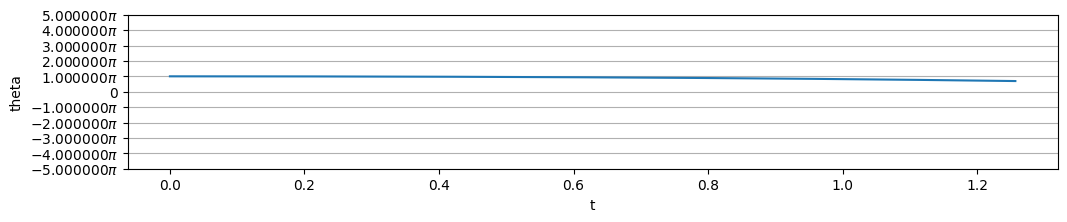

In [72]:
# Plotting and animation

# plot pendulum angle versus time
t_plot = np.linspace(t_min, t_max, 1000)
theta_plot = sol.sol(t_plot)[0]
ang_vel_plot = sol.sol(t_plot)[1]

# construct plot
plt.figure(figsize=(12, 2))
plt.plot(t_plot, theta_plot)
plt.ylim(-5*np.pi, 5*np.pi)
plt.xlabel('t')
plt.ylabel('theta')
y_ticks = np.arange(-5 *np.pi, 5 * np.pi + np.pi/2, np.pi) # generate ticks -2pi to 2pi with steps of pi
y_labels = [f'${{{tick/np.pi:0f}}}\pi$' if tick != 0 else '0' for tick in y_ticks] # generate latex labels
plt.yticks(y_ticks, y_labels)
plt.grid(axis='y') # add horizontal gridlines
plt.show()

In [73]:
# create pendulum animation
def create_pendulum_animation(t, x_pivot, y_pivot, x_lab, y_lab, l=1, show_traj=False, speed_factor=1.0):
    """
    Creates an animation of the pivot-driven pendulum.

    PARAMETERS:
    t : ndarray
        Time array.
    x_pivot : ndarray
        x-positions of the pivot over time.
    y_pivot : ndarray
        y-positions of the pivot over time.
    x_lab : ndarray
        x-positions of the pendulum bob in the lab frame over time.
    y_lab : ndarray
        y-positions of the pendulum bob in the lab frame over time.
    l : float, optional
        pendulum length (default is 1).
    show_traj : bool, optional
        toggle showing the trajectory of the pendulum bob (default is False).
    speed_factor : float, optional
        factor to scale the animation speed (default is 1.0).
        a value > 1.0 slows down the animation, < 1.0 speeds it up.

    RETURNS:
    anim : FuncAnimation
        matplotlib animation object.
    """
    fig, ax = plt.subplots(figsize=(4, 4)) # Increased figure size
    ax.set_xlim(np.min(x_pivot) - l, np.max(x_pivot) + l)
    ax.set_ylim(np.min(y_pivot) - l, np.max(y_pivot) + l)
    # ax.set_aspect('equal', adjustable='box')
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Initialize plot elements
    pivot, = ax.plot([], [], 'o', color='black', markersize=8, label='Pivot')
    pendulum_arm, = ax.plot([], [], '-', color='black', lw=2, label='Pendulum Arm')
    pendulum_bob, = ax.plot([], [], 'o', color='red', markersize=12, label='Pendulum Bob')
    trajectory = None # Initialize trajectory to None

    if show_traj:
        trajectory, = ax.plot([], [], '-', color='gray', lw=1, alpha=0.5, label='Trajectory') # Add trajectory line

    def animate(i):
        # Update the positions of the plot elements
        pivot.set_data([x_pivot[i]], [y_pivot[i]]) # Pass as sequences
        pendulum_arm.set_data([x_pivot[i], x_lab[i]], [y_pivot[i], y_lab[i]])
        pendulum_bob.set_data([x_lab[i]], [y_lab[i]]) # Pass as sequences

        artists = [pivot, pendulum_arm, pendulum_bob] # List of artists to update

        if show_traj and trajectory:
             trajectory.set_data(x_lab[:i+1], y_lab[:i+1]) # Update trajectory data
             artists.append(trajectory) # Add trajectory to the list of artists

        return artists # Return all updated artists

    # Create the animation
    # Adjust the interval based on the average time step in t
    # This aims to make the animation speed consistent with the simulation time
    average_time_step = np.mean(np.diff(t))
    # Scale the interval by the speed_factor
    interval = average_time_step * 1000 * speed_factor # Convert to milliseconds and apply speed_factor.

    anim = FuncAnimation(fig, animate, frames=len(t), interval=interval, blit=True)
    plt.close(fig) # Close the initial figure to prevent it from displaying

    return anim

In [74]:
# animate motion
# plot pendulum angle versus time
# get coordinates for plotting
n_points = 300 # number of frames
t_plot = np.linspace(t_min, t_max, n_points)
theta_plot = sol.sol(t_plot)[0] # requires `dense_output=True` in `solve_ivp`
x_pivot, y_pivot = get_pivot_xy(t_plot, omega_d, l, x_p0, y_p0) # pivot coordinates
x_pendulum, y_pendulum = get_pendulum_xy(t_plot, theta_plot, g, l) # pendulum coordinates of pendulum (referenced to pivot point)
x_lab, y_lab = get_lab_xy(x_pivot, y_pivot, x_pendulum, y_pendulum)

# animation flags/parameters
show_traj = True # True --> show trajectory; False --> do not show trajectory
speed_factor = 5 # >1 --> slow down animation; <1 --> speed up animation

# create_pendulum_animation
pendulum_animation = create_pendulum_animation(t_plot, x_pivot, y_pivot, x_lab, y_lab, show_traj=show_traj, speed_factor=speed_factor) # create animation object with trajectory shown
HTML(pendulum_animation.to_html5_video()) # display animation

## Stability analysis

The solution we found where the mass stays mostly still in the center is an unstable solution. Slight changes in gamma will make the mass move very far away from the center. Because the solution is sinusoidal, changing the phase will result in a stable solution but not where the mass is in the center; the mass instead stays at mostly constant theta outside the circle, "drawing" a picture of a circle with radius 2l.